# [Project 4: Depth Estimation using Stereo](https://www.cc.gatech.edu/~hays/compvision/proj4_part1.pdf)    

## **Part 1: Simple stereo by matching patches** 

(1) Random dot stereogram           
(2) Similarity measure       
(3) Disparity map    
(4) Error profile analysis     
(5) Real life stereo images           
(6) Smoothing             

## Setup

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import matplotlib.pyplot as plt
from proj4_code.utils import load_image, PIL_resize, stereo_helper_fn, verify

## 1.1 Random dot stereogram

It was once believed that in order to perceive depth, one must either match feature points (like SIFT) between left and right images, or rely upon clues such as shadows.

A random dot stereogram eliminates all other depth cues, and hence proves that a  stereo setup is sufficient  to  get  an idea of the depth of the scene.   

A  random  dot  stereogram  is  generated  by  the  following steps:
1.  Create the left image with random dots at each pixel (0/1 values).
2.  Create the right image as a copy of the left image.
3.  Select a region in the right image and shift it horizontally.
4.  Add a random pattern in the right image in the empty region created after the shift.

In `part1a_random_stereogram.py`, you will implement `generate_random_stereogram()` to generate a randomdot stereogram for the given image size.

In [2]:
from proj4_code.part1a_random_stereogram import generate_random_stereogram
from proj4_unit_tests.test_part1a_random_stereogram import test_generate_random_stereogram

#### Generate the random stereogram

In [3]:
# generate left and right images
im_left, im_right = generate_random_stereogram(im_size=(51, 51, 3))

In [4]:
print('Test for random dot stereogram', verify(test_generate_random_stereogram))

Test for random dot stereogram "Correct"


#### Visualize the random stereogram

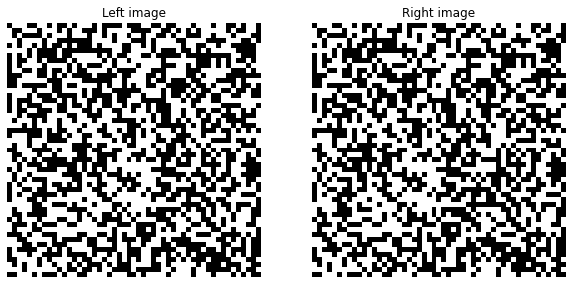

In [5]:
# plot the left and right images 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

ax1.imshow(im_left, interpolation=None)
ax1.title.set_text("Left image")
ax1.autoscale(False)
ax1.set_axis_off()

ax2.imshow(im_right, interpolation=None)
ax2.title.set_text("Right image")
ax2.autoscale(False)
ax2.set_axis_off()

plt.show()

## 1.2 Similarity measure

To compute the difference between the two images, we will need to define some similarity measures.

Two such measures we will use are:
1. Sum of Squared Differences (SSD):

    $SSD = \sum_{i \in [0,H], j \in [0,W]} (A_{i,j} - B_{i,j}) ^ 2$
    
1. Sum of Absolute Differences (SAD):

    $SAD = \sum_{i \in [0,H], j \in [0,W]} |A_{i,j} - B_{i,j}|$

Implement ```ssd_similarity_measure()``` and ```sad_similarity_measure()``` in ```part1b_similarity_measures.py``` to define the SSD and SAD measures.

W'll use them to compare patches between the left and right images.

In [6]:
from proj4_unit_tests.test_part1b_similarity_measures import (
  test_ssd_similarity_measure_values, 
  test_sad_similarity_measure_values, 
  test_similarity_measure_size_compatibility
)

print('Testing value for SAD measure', verify(test_sad_similarity_measure_values))
print('Testing value for SSD measure', verify(test_ssd_similarity_measure_values))
print('Testing input size compatibility for measures', verify(test_similarity_measure_size_compatibility))

Testing value for SAD measure "Correct"
Testing value for SSD measure "Correct"
Testing input size compatibility for measures "Correct"


## 1.3 Disparity map 

Implement ```calculate_disparity_map()``` in ```part1c_disparity_map.py``` to calculate the disparity value at each pixel by searching a small patch around a pixel from the left image in the right image.

#### Testing

Make sure your code works!

In [7]:
from proj4_unit_tests.test_part1c_disparity_map import (
  test_disparity_deltafn_failure,
  test_disparity_deltafn_success,
  test_disparity_map_size,
  test_disparity_random_stereogram,
  test_disparity_translation_shift
)

print('Testing for disparity map on a delta function', verify(test_disparity_deltafn_failure))
print('Testing for disparity map on a delta function', verify(test_disparity_deltafn_success))
print('Testing disparity map size', verify(test_disparity_map_size))
print('Testing random stereogram ouptut', verify(test_disparity_random_stereogram))
print('Testing disparity on translation shift', verify(test_disparity_translation_shift))

tensor([[33, 24]])
Testing for disparity map on a delta function "Correct"
Testing for disparity map on a delta function "Correct"
Testing disparity map size "Correct"
Testing random stereogram ouptut "Correct"
Testing disparity on translation shift "Correct"


### Visualize disparity maps

We'll calculate and plot the images of disparity maps using SAD and SSD similarity function. 

You can tune the parameters and see the effect of them for different inputs.

From the docstring of `stereo_helper_fn`:

This helper function will help us in calculating disparity maps for different parameters.
It also plots the image.

Please tune the parameters and see the effect of them for different inputs.

Args:
  - im_left: the left image
  - im_right: the right image
  - block_size: list of different block sizes to be used
  - max_search_bound: the max horizontal displacement to look for the most similar patch

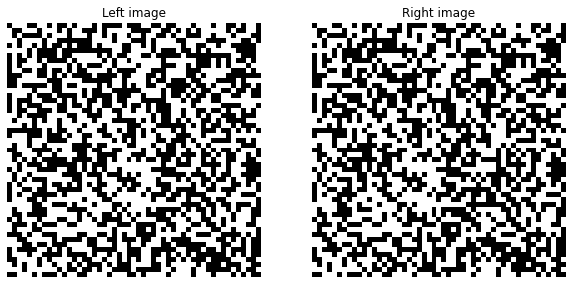

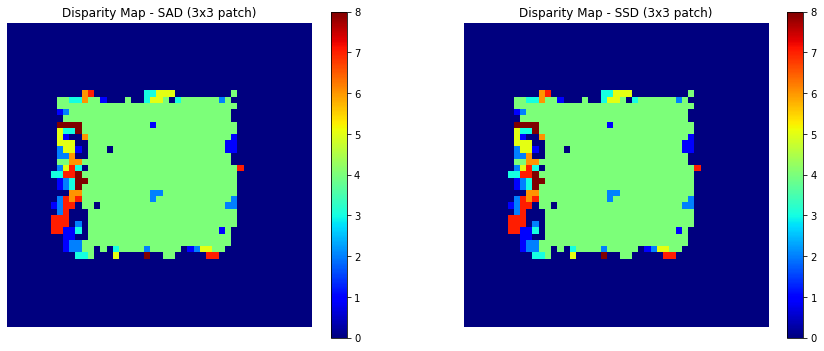

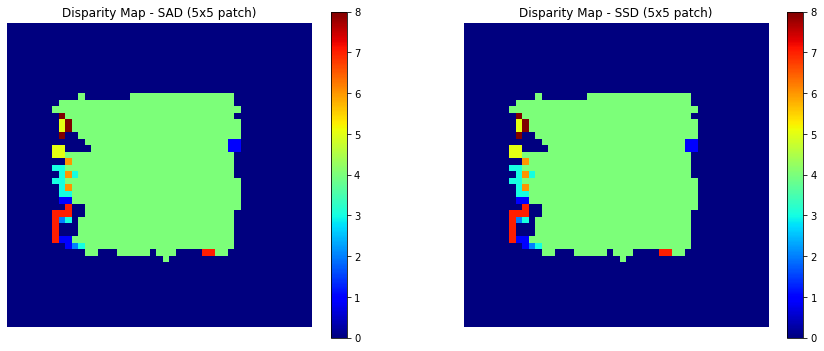

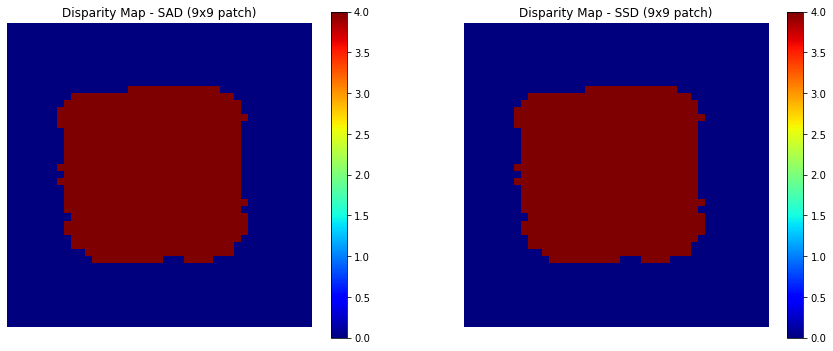

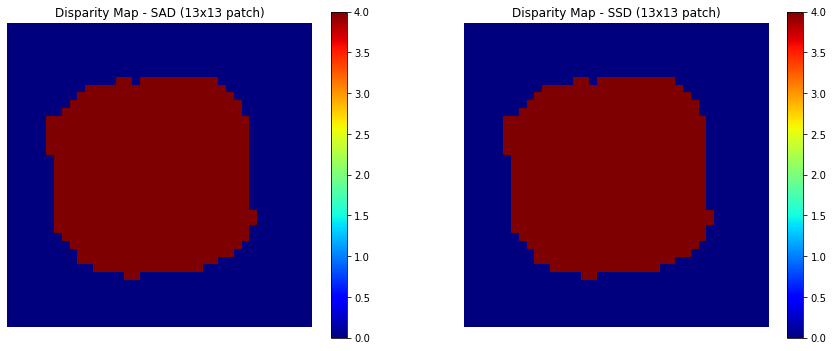

In [8]:
stereo_helper_fn(im_left, im_right, block_size = [3,5,9,13], max_search_bound=8)

## 1.4 Error profile analysis

The error profile is a visualization of the error function between the image that we're comparing to, and a patch in the search window of the other image.

Let's take a look at the images we'll be generating error profiles for

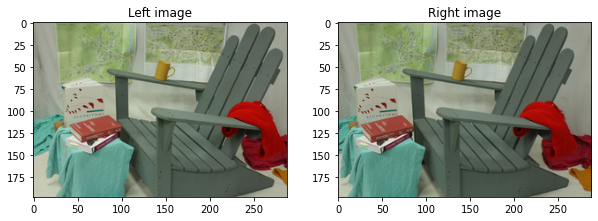

In [9]:
# load the image
base_path = '../data/adirondack/'
im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.1, 0.1))
im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.1, 0.1))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))

ax1.imshow(im_left, interpolation=None)
ax1.title.set_text('Left image')
ax1.autoscale(False)
ax1.set_axis_on()

ax2.imshow(im_right, interpolation=None)
ax2.title.set_text('Right image')
ax2.autoscale(False)
ax2.set_axis_on()

plt.show()

### Convex error profile

Convex error profiles have a distinct minimum, and correspond to a convex function, i.e. they are monotonically decreasing to the left of the minimum, and monotonically increasing to the right

Let's try to find different patches in the image which exhibit a close-to-convex error profile

Replace the `None`s in the cell below to the top left corner of a 15x15 patch from the images that will generate a close-to-convex error profile

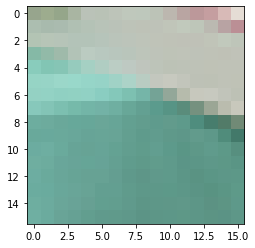

In [10]:
# extract a patch of interest from the left image
patch_size=15
x_idx, y_idx = (140, 48)
patch_left_img = torch.tensor(im_left[x_idx:x_idx+patch_size+1, y_idx:y_idx+patch_size+1,:])
plt.imshow(patch_left_img)
plt.show()

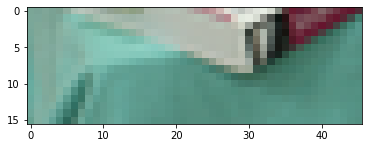

In [11]:
# get the search area in the right image
max_search_bound = 30 # Adjust your search bound based on the (x_idx, y_idx) you chose
search_area_right_img = torch.tensor(
  im_right[x_idx:x_idx+patch_size+1, y_idx-max_search_bound:y_idx+patch_size+1,:]
)
plt.imshow(search_area_right_img)
plt.show()

### Visualize the error profile

The block below visualizes the error profile you generated for the patch you selected.

For example:
![Convex Error Profile](https://user-images.githubusercontent.com/16724970/111714792-d47d8f80-8828-11eb-9b65-eb0153691e35.png)

In practice, the actual error profile may be slightly non-convex, but the overall effect remains the same.  Make sure that your error profile _looks_ convex, and answer the questions according to the patches you found that result in this kind of error profile.

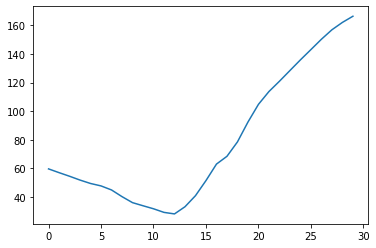

In [12]:
from proj4_code.part1b_similarity_measures import sad_similarity_measure

similarity_vals = np.array(
  [sad_similarity_measure(patch_left_img, search_area_right_img[:,h_idx:h_idx+patch_size+1,:]) 
   for h_idx in range(search_area_right_img.shape[1]-patch_size-1)
  ])
plt.plot(similarity_vals)
plt.show()

### Non-Convex error profile

Now, let's visualize non-convex error profiles. Unlike convex profiles, they aren't monotonically increasing or decreasing.

Replace the `None`s in the cell below to the top left corner of a 15x15 patch from the images that will generate a close-to-convex error profile

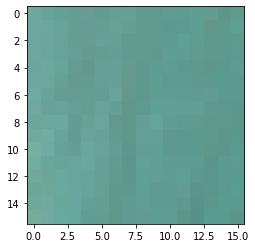

In [13]:
# extract a patch of interest from the left image
patch_size=15
x_idx, y_idx = (175, 50) # replace with integers as before
patch_left_img = torch.tensor(im_left[x_idx:x_idx+patch_size+1, y_idx:y_idx+patch_size+1,:])
plt.imshow(patch_left_img)
plt.show()

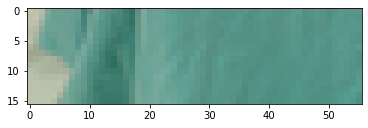

In [14]:
# get the search area in the right image
max_search_bound = 40 # set this value based on your (x_idx, y_idx) (needs to be an integer)
search_area_right_img = torch.tensor(
  im_right[x_idx:x_idx+patch_size+1, y_idx-max_search_bound:y_idx+patch_size+1,:]
)
plt.imshow(search_area_right_img)
plt.show()

### Visualizing non-convex error profile

Find patches that generate a highly non-convex error profile

Example:
![Non-Convex Error Profile](https://user-images.githubusercontent.com/16724970/111714795-d47d8f80-8828-11eb-94f3-be882116b78e.png)

This example shows a non-convex error profile, but non convexity can be highly diverse! Make sure that your error profile _looks_ non-convex, and answer the questions according to the patches you found that result in this kind of error profile.

Run the code below to generate the error profile for the patch you chose

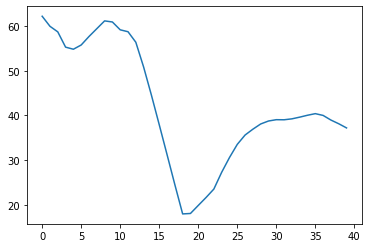

In [15]:
similarity_vals = np.array(
  [sad_similarity_measure(patch_left_img, search_area_right_img[:,h_idx:h_idx+patch_size+1,:]) 
   for h_idx in range(search_area_right_img.shape[1]-patch_size-1)
  ])
plt.plot(similarity_vals)
plt.show()

## 1.5 Real life stereo images

Now, let's generate disparity maps for real-life stereo images. The code blocks below will iterate through pairs of images from the dataset and calculate the disparity maps for images. You don't need to change anything; just run the code, include the visualizations in the report (wherever they are asked for) and answer the questions!

### Set 1: Adirondack

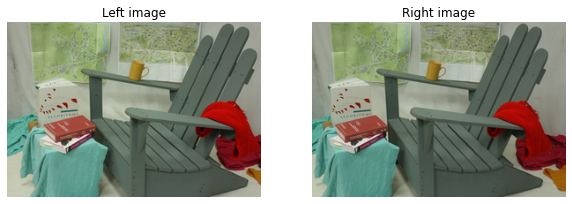

KeyboardInterrupt: 

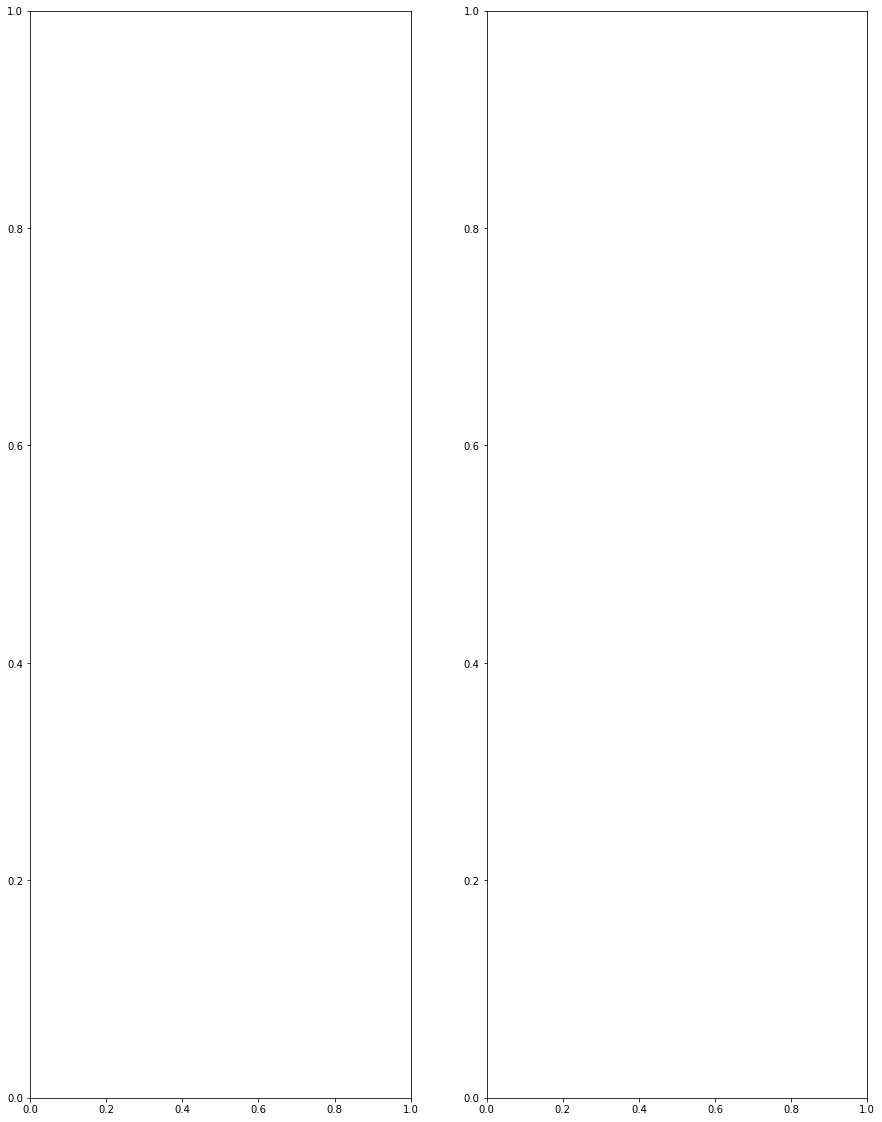

In [16]:
base_path = '../data/adirondack/'
im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.1, 0.1))
im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.1, 0.1))

stereo_helper_fn(torch.tensor(im_left), torch.tensor(im_right), max_search_bound=25)

### Set 2: Bicycle

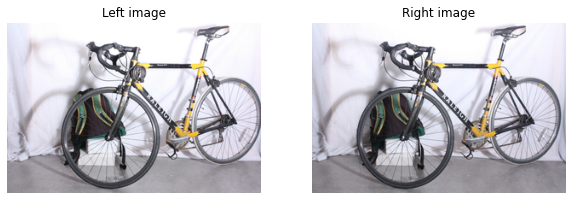

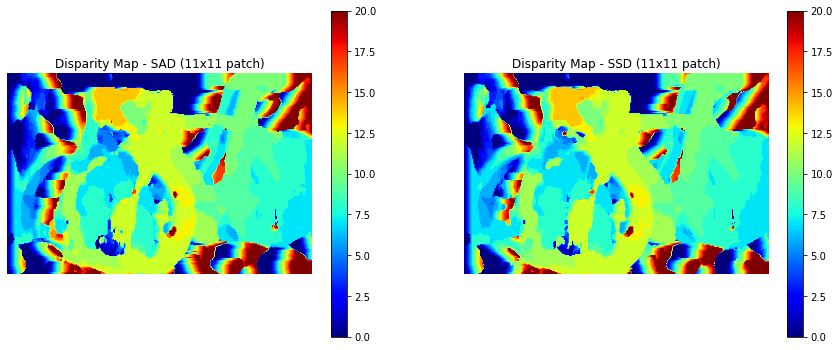

In [20]:
base_path = '../data/bicycle/'
im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.1, 0.1))
im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.1, 0.1))

stereo_helper_fn(torch.tensor(im_left), torch.tensor(im_right), block_size=[11], max_search_bound=20)

### Set 3: Bowling

In [ ]:
base_path = '../data/bowling/'
im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.2, 0.2))
im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.2, 0.2))

stereo_helper_fn(torch.tensor(im_left), torch.tensor(im_right), block_size=[9], max_search_bound=30)

### Set 4: Bowling 2

In [ ]:
base_path = '../data/bowling2/'
im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.20, 0.20))
im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.20, 0.20))

stereo_helper_fn(torch.tensor(im_left), torch.tensor(im_right), block_size=[9], max_search_bound=30)

### Set 5: Flowers

In [ ]:
base_path = '../data/flowers/'
im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.10, 0.10))
im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.10, 0.10))

stereo_helper_fn(torch.tensor(im_left), torch.tensor(im_right), block_size=[9], max_search_bound=30)

### Set 6: Stairs

In [ ]:
base_path = '../data/stairs/'
im_left = PIL_resize(load_image(base_path + 'im_left.jpg'), (1, 1))
im_right = PIL_resize(load_image(base_path + 'im_right.jpg'), (1, 1))

stereo_helper_fn(torch.tensor(im_left), torch.tensor(im_right), block_size = [3, 5, 7], max_search_bound=15)

## 1.6 Smoothing

Let's smooth the images using semi-global matching (read the handout for more details on how it works).

Implement the calculation of the cost-volume in `calculate_cost_volume` in `part1c_disparity_map.py`. You are encouraged to reuse any code you have written till now.

Before we visualize the smoothed disparity maps, we need to ensure that the cost-volume calculation is error free. Run the block below to check whether you have any errors or not.

In [17]:
from proj4_unit_tests.test_part1c_disparity_map import (
  test_calculate_cost_volume
)

print('Testing for calculate_cost_volume', verify(test_calculate_cost_volume))

Testing for calculate_cost_volume "Correct"


In [18]:
from proj4_code.part1b_similarity_measures import ssd_similarity_measure, sad_similarity_measure
from scipy import ndimage
from semiglobalmatching.sgm import sgm
import matplotlib.pyplot as plt

## Visualize smoothed disparity maps

We'll make use of the `calculate_cost_volume` function you implemented to perform semi-global matching, and visualize the smoothed disparity maps.

Observe the differences between the disparity maps you visualized earlier, and their smoothed versions, and answer the questions in your report.

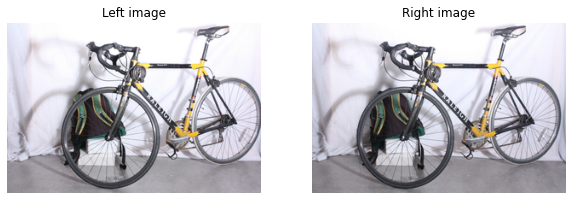


Starting cost computation...

Starting aggregation computation...
	Processing paths east and west...	(done in 3.32 s)
	Processing paths south-east and north-west...	(done in 3.41 s)
	Processing paths south and north...	(done in 3.38 s)
	Processing paths south-west and north-east...	(done in 3.42 s)

Selecting best disparities...

Done


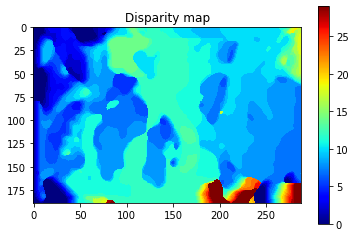

In [21]:
# load the image
# feel free to try other pairs, but you may need to fix the scaling per pair
# base_path = '../data/adirondack/'
# im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.10, 0.10))
# im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.10, 0.10))

base_path = '../data/bicycle/'
im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.1, 0.1))
im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.1, 0.1))

# base_path = '../data/bowling/'
# im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.2, 0.2))
# im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.2, 0.2))

# base_path = '../data/bowling2/'
# im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.20, 0.20))
# im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.20, 0.20))

# base_path = '../data/flowers/'
# im_left = PIL_resize(load_image(base_path + 'im_left.png'), (0.10, 0.10))
# im_right = PIL_resize(load_image(base_path + 'im_right.png'), (0.10, 0.10))

# base_path = '../data/stairs/'
# im_left = PIL_resize(load_image(base_path + 'im_left.jpg'), (1, 1))
# im_right = PIL_resize(load_image(base_path + 'im_right.jpg'), (1, 1))

# show the img
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(im_left, interpolation=None)
ax1.title.set_text("Left image")
ax1.autoscale(False)
ax1.set_axis_off()
ax2.imshow(im_right, interpolation=None)
ax2.title.set_text("Right image")
ax2.autoscale(False)
ax2.set_axis_off()
plt.show()

# calculate the disparity map with SGM, the last argument is max disparity to consider
disparity_map = sgm(im_left,im_right, "result", 30, sad_similarity_measure, 9)
result = ndimage.median_filter(disparity_map, size=5)
plt.figure()
plt.imshow(result, cmap='jet', interpolation='nearest')
plt.title('Disparity map')
plt.colorbar()
plt.show()